# Exploration of California's Electric Vehicle (EV) and Hydrogen Vehicle (HY) Charging Infrastructure

CP 255 Final Project

Yin Qiu, MIMS'21, School of Information, UC Berekeley

### Project Motivation
This final project topic is about Charging Infrastructure for California's Zero Emission Vehicles. This year, California Governer Newsom put forward a mandate that from 2035 only zero-emission cars can be sold, which is an exciting big move to steer the wheel towards a decarbonized and sustainable future. However, the road to decarbonation requires more than just landing the cleaner cars on the road. Imagine 15 years from now, most of the cars running on the road today will be replaced with newer models and newer technologies. One of the key concerns for car owners to buy a zero-emission car is whether there are enough accessible charging/fuel stations. Electric Vehicles and Hydrogen (Fuel Cell) Vehicles stand out as two very promising technologies. Policy makers need to pay attention to charging infrastructure when they roll out the plan.

### Project Goal
The project is aiming to explore the status quo and understand the locations and characteristics of current EV/HY charging stations. I will explore the nunber of charging stations available in different tracts and counties, and find out which tracts and counties are at the top and bottom of the list, so that we can have a sense of equity. I will also combine the EV stations dataset with the demographic information (county population, county median household income) for some statistical analysis.

### Project Plan
The project consists of five sections:
1. request API and download geojson and shapefile (requests, geojson, json)
2. data preprocessing and geoprocessing (pandas, geopandas, geojson, shapely)
3. mapping of EV stations and HY stations, both static and interactive (mapboxgl)
4. exploratory data analysis, including characteristics and distribution of stations in tracts and counties (numpy, pandas, geopandas, matplotlib, seaborn)
5. OLS linear regression to understand how population and median household income are correlated with number of stations (statsmodels)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
%matplotlib inline
pylab.rcParams['figure.figsize'] = 10, 8

import json
import requests
from geojson import Feature, Point, FeatureCollection
import geopandas as gpd
from geopandas import GeoDataFrame
import fiona
from shapely.geometry import Point
from scipy import ndimage
from pyproj import CRS

import pprint
pp = pprint.PrettyPrinter()

from API_keys import nrel_token, census_token, mapbox_token

# Section 1: Request API and Download Data

### Dataset 1: EV charging stations and Hydrogen fueling stations
Documentation: https://developer.nrel.gov/docs/transportation/alt-fuel-stations-v1/all/

In [2]:
# NREL API request, California EV charging and Hydrogen fueling stations data
endpoint_url = 'https://developer.nrel.gov/api/alt-fuel-stations/v1.geojson?'+'api_key='+nrel_token+'&fuel_type=ELEC,HY&state=CA'
response = requests.get(endpoint_url)
results = response.text

In [3]:
data = json.loads(results)
# save a copy of raw station data
with open('data/raw_data_stations.geojson', 'w') as outfile:
    json.dump(data['features'], outfile)

In [4]:
pp.pprint(data['features'][:1])

[{'geometry': {'coordinates': [-118.3879713743439, 34.2483191527193],
               'type': 'Point'},
  'properties': {'access_code': 'private',
                 'access_days_time': 'Fleet use only',
                 'access_days_time_fr': None,
                 'access_detail_code': None,
                 'bd_blends': None,
                 'bd_blends_fr': None,
                 'cards_accepted': None,
                 'city': 'Sun Valley',
                 'cng_dispenser_num': None,
                 'cng_fill_type_code': None,
                 'cng_psi': None,
                 'cng_renewable_source': None,
                 'cng_total_compression': None,
                 'cng_total_storage': None,
                 'cng_vehicle_class': None,
                 'country': 'US',
                 'date_last_confirmed': '2020-09-03',
                 'e85_blender_pump': None,
                 'e85_other_ethanol_blends': None,
                 'ev_connector_types': ['CHADEMO', 'J1772', 'J177

In [5]:
# parse station data to geopandas
collection = FeatureCollection(data)
gdf_stations = gpd.GeoDataFrame.from_features(collection['features'])
gdf_stations = gdf_stations[gdf_stations.geometry.isnull()==False] # omit those without geometry

In [6]:
# view first few lines of raw station data
gdf_stations.head(5)

geometry access_code                 access_days_time  \
0  POINT (-118.38797 34.24832)     private                   Fleet use only   
1  POINT (-118.08101 34.05074)     private                Employee use only   
2  POINT (-118.27139 34.04054)      public          24 hours daily; pay lot   
3  POINT (-118.24859 34.05913)     private  For fleet and employee use only   
4  POINT (-118.33476 34.10240)      public          24 hours daily; pay lot   

  access_detail_code cards_accepted date_last_confirmed expected_date  \
0               None           None          2020-09-03          None   
1               None           None          2020-01-13          None   
2               None           None          2020-11-09          None   
3               None           None          2020-11-09          None   
4               None           None          2019-05-09          None   

  fuel_type_code groups_with_access_code    id  ... ng_fill_type_code ng_psi  \
0           ELEC                 Private  1517  ...              None   None   
1           ELEC                 Private  1520  ...              None   None   
2           ELEC                  Public  1523  ...              None   None   
3           ELEC                 Private  1525  ...              None   None   
4           ELEC                  Public  1526  ...              None   None   

  ng_vehicle_class access_days_time_fr intersection_directions_fr  \
0             None                None                       None   
1             None                None                       None   
2             None                None                       None   
3             None                None                       None   
4             None                None                       None   

  bd_blends_fr groups_with_access_code_fr ev_pricing_fr federal_agency  \
0         None                      Privé          None            NaN   
1         None                      Privé          None            NaN   
2         None                     Public          None            NaN   
3         None                      Privé          None            NaN   
4         None                     Public          None            NaN   

  ev_network_ids  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  

[5 rows x 62 columns]

### Dataset 2: California Tracts - Census Cartographic Boundary
Cartographic Boundary Shape files

download source: https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html

<AxesSubplot:>

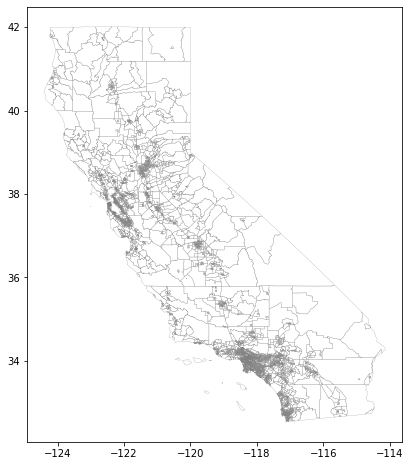

In [7]:
# parse shape files to geopandas
# blockgroups = gpd.read_file('data/cb_2019_06_bg_500k/cb_2019_06_bg_500k.shp')
# blockgroups.plot(color='none', edgecolor='gray', linewidth=.2, figsize=(12,8))

tracts = gpd.read_file('data/cb_2019_06_tract_500k/cb_2019_06_tract_500k.shp')
tracts.plot(color='none', edgecolor='gray', linewidth=.2, figsize=(12,8))

In [8]:
tracts.head()

STATEFP COUNTYFP TRACTCE              AFFGEOID        GEOID     NAME LSAD  \
0      06      013  370000  1400000US06013370000  06013370000     3700   CT   
1      06      001  442301  1400000US06001442301  06001442301  4423.01   CT   
2      06      037  405101  1400000US06037405101  06037405101  4051.01   CT   
3      06      037  199800  1400000US06037199800  06037199800     1998   CT   
4      06      037  291300  1400000US06037291300  06037291300     2913   CT   

     ALAND  AWATER                                           geometry  
0   999356       0  POLYGON ((-122.32697 37.93502, -122.32610 37.9...  
1  1429049       0  POLYGON ((-121.97010 37.53047, -121.96894 37.5...  
2  1121229       0  POLYGON ((-117.96926 34.09945, -117.96489 34.0...  
3   651258       0  POLYGON ((-118.21562 34.07364, -118.21036 34.0...  
4  2353751   45836  POLYGON ((-118.30915 33.86198, -118.30915 33.8...

In [9]:
# cartographic boundary for counties
counties = tracts.dissolve(by='TRACTCE')

# Section 2: Data Preprocessing

In [10]:
# raw data shape of EV charging stations, 7710 rows and 62 columns
gdf_stations.query("fuel_type_code == 'ELEC'").shape

(7687, 62)

In [11]:
# raw data shape of hydrogen stations, 101 rows and 62 columns
gdf_stations.query("fuel_type_code == 'HY'").shape

(101, 62)

In [12]:
# check raw data column names
gdf_stations.columns

Index(['geometry', 'access_code', 'access_days_time', 'access_detail_code',
       'cards_accepted', 'date_last_confirmed', 'expected_date',
       'fuel_type_code', 'groups_with_access_code', 'id', 'open_date',
       'owner_type_code', 'status_code', 'station_name', 'station_phone',
       'updated_at', 'facility_type', 'geocode_status', 'city',
       'intersection_directions', 'plus4', 'state', 'street_address', 'zip',
       'country', 'bd_blends', 'cng_dispenser_num', 'cng_fill_type_code',
       'cng_psi', 'cng_renewable_source', 'cng_total_compression',
       'cng_total_storage', 'cng_vehicle_class', 'e85_blender_pump',
       'e85_other_ethanol_blends', 'ev_connector_types', 'ev_dc_fast_num',
       'ev_level1_evse_num', 'ev_level2_evse_num', 'ev_network',
       'ev_network_web', 'ev_other_evse', 'ev_pricing', 'ev_renewable_source',
       'hy_is_retail', 'hy_pressures', 'hy_standards', 'hy_status_link',
       'lng_renewable_source', 'lng_vehicle_class', 'lpg_primary',
    

In [13]:
# select and only keep relevant columns
gdf_stations = gdf_stations[['geometry', 'access_code',
             'date_last_confirmed', 'expected_date',
             'fuel_type_code', 'id', 'open_date',
             'owner_type_code', 'status_code', 'station_name',
             'updated_at', 'facility_type', 'geocode_status', 'city',
             'state', 'street_address', 'zip','country',
             'ev_connector_types', 'ev_dc_fast_num','ev_level1_evse_num', 'ev_level2_evse_num',
             'ev_network','ev_network_web', 'ev_other_evse', 'ev_pricing', 'ev_renewable_source','ev_network_ids',
             'hy_is_retail', 'hy_pressures', 'hy_standards', 'hy_status_link', 'federal_agency']]

In [14]:
# check data shape after filter columns
gdf_stations.shape

(7788, 33)

In [15]:
# set crs to epsg: 4326
gdf_stations.crs = CRS('epsg:4326')
# blockgroups.crs = CRS('epsg:4326')
tracts.crs = CRS('epsg:4326')
counties.crs = tracts.crs

In [16]:
# check crs
# print(blockgroups.crs）
print(tracts.crs, counties.crs)
print(gdf_stations.crs)

epsg:4326 epsg:4326
epsg:4326


In [17]:
# clip stations outside California
gdf_stations = gpd.clip(gdf_stations, tracts)

In [18]:
# check data shape after filter stations for CA only
gdf_stations.shape

(7785, 33)

MTC has standardized on Universal Transverse Mercator (UTM), Zone 10N, NAD83 for all analysis based projects.

In [19]:
# projection from 4326 to mtc
mtc_crs = '+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs'

# blockgroups_proj = blockgroups.to_crs(mtc_crs)
tracts_proj = tracts.to_crs(mtc_crs)
counties_proj = counties.to_crs(mtc_crs)
gdf_stations_proj = gdf_stations.to_crs(mtc_crs)

In [20]:
# check crs after projection
# print(blockgroups_proj.crs）
print(tracts_proj.crs, counties_proj.crs)
print(gdf_stations_proj.crs)

+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs +type=crs +proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs +type=crs
+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs +type=crs


# Section 3: Mapping of EV and HY Stations

### Static Map: overview of all EV and HY charging stations

<Figure size 1296x720 with 0 Axes>

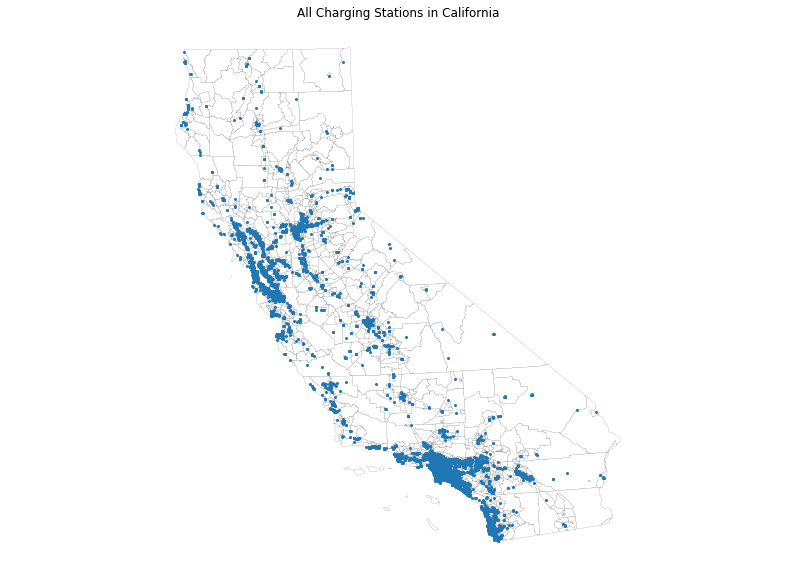

In [21]:
# mapping with base of tracts
ax = plt.figure(figsize=(18, 10))
ax = tracts_proj.plot(color='white', edgecolor='black', linewidth=.1, figsize=(14,10))
ax.set_title('All Charging Stations in California')
DPI=100
gdf_stations_proj.plot(ax=ax, markersize=4)
ax.set_axis_off()
plt.axis('equal')
plt.savefig('data/All Charging Stations CA.png', dpi=DPI, bbox_inches='tight')


### Interactive Maps: where EV charging and HY charging stations are located, and where the clusters are
Use Mapboxgl library to plot geojson data

documentation: https://github.com/mapbox/mapboxgl-jupyter

In [22]:
from mapboxgl.utils import *
from mapboxgl.viz import *
import os
import warnings; warnings.simplefilter('ignore')

In [23]:
# extract lon and lat coordinates from the geometry column
gdf_stations['lon'] = gdf_stations['geometry'].x
gdf_stations['lat'] = gdf_stations['geometry'].y

In [24]:
gdf_stations.head(2)

geometry access_code date_last_confirmed expected_date  \
0  POINT (-118.38797 34.24832)     private          2020-09-03          None   
1  POINT (-118.08101 34.05074)     private          2020-01-13          None   

  fuel_type_code    id   open_date owner_type_code status_code  \
0           ELEC  1517  1999-10-15              LG           E   
1           ELEC  1520  2011-08-01               T           E   

                                        station_name  ... ev_pricing  \
0                           LADWP - Truesdale Center  ...       None   
1  Southern California Edison - Rosemead Office B...  ...       None   

  ev_renewable_source ev_network_ids hy_is_retail hy_pressures hy_standards  \
0                None            NaN         None         None         None   
1                None            NaN         None         None         None   

  hy_status_link federal_agency         lon        lat  
0           None            NaN -118.387971  34.248319  
1           None            NaN -118.081014  34.050745  

[2 rows x 35 columns]

In [25]:
# create a pandas df
df_stations = pd.DataFrame(gdf_stations)
df_stations.drop('geometry', axis=1, inplace=True)
df_stations.head(2)

access_code date_last_confirmed expected_date fuel_type_code    id  \
0     private          2020-09-03          None           ELEC  1517   
1     private          2020-01-13          None           ELEC  1520   

    open_date owner_type_code status_code  \
0  1999-10-15              LG           E   
1  2011-08-01               T           E   

                                        station_name            updated_at  \
0                           LADWP - Truesdale Center  2020-09-03T19:35:48Z   
1  Southern California Edison - Rosemead Office B...  2020-07-20T18:42:03Z   

   ... ev_pricing ev_renewable_source ev_network_ids hy_is_retail  \
0  ...       None                None            NaN         None   
1  ...       None                None            NaN         None   

  hy_pressures hy_standards hy_status_link federal_agency         lon  \
0         None         None           None            NaN -118.387971   
1         None         None           None            NaN -118.081014   

         lat  
0  34.248319  
1  34.050745  

[2 rows x 34 columns]

In [26]:
# save to csv file
df_stations.to_csv('data/all_stations.csv')
df_ev = df_stations[df_stations['fuel_type_code']=='ELEC']
df_ev.to_csv('data/ev_stations.csv')
df_hy = df_stations[df_stations['fuel_type_code']=='HY']
df_hy.to_csv('data/hy_stations.csv')

In [27]:
# save to geojson file
df_to_geojson(
      df_stations,
      filename="data/all_stations.geojson",
      properties=['access_code',
             'date_last_confirmed', 'expected_date',
             'fuel_type_code', 'id', 'open_date',
             'owner_type_code', 'station_name',
             'facility_type', 'geocode_status', 'city',
             'state', 'street_address', 'zip','country',
             'ev_connector_types', 'ev_dc_fast_num','ev_level1_evse_num', 'ev_level2_evse_num',
             'ev_network','ev_network_web', 'ev_other_evse', 'ev_pricing', 'ev_network_ids',
             'hy_is_retail', 'hy_pressures', 'hy_standards', 'hy_status_link', 'federal_agency'],
      lat = 'lat',
      lon = 'lon',
      precision=4)

{'type': 'file',
 'filename': 'data/all_stations.geojson',
 'feature_count': 7785}

In [28]:
df_to_geojson(
      df_ev,
      filename="data/ev_stations.geojson",
      properties=['access_code',
             'date_last_confirmed', 'expected_date',
             'fuel_type_code', 'id', 'open_date',
             'owner_type_code', 'station_name',
             'facility_type', 'geocode_status', 'city',
             'state', 'street_address', 'zip','country',
             'ev_connector_types', 'ev_dc_fast_num','ev_level1_evse_num', 'ev_level2_evse_num',
             'ev_network','ev_network_web', 'ev_other_evse', 'ev_pricing', 'ev_network_ids'],
      lat = 'lat',
      lon = 'lon',
      precision=4)

{'type': 'file', 'filename': 'data/ev_stations.geojson', 'feature_count': 7684}

In [29]:
df_to_geojson(
      df_hy,
      filename="data/hy_stations.geojson",
      properties=['access_code',
             'date_last_confirmed', 'expected_date',
             'fuel_type_code', 'id', 'open_date',
             'owner_type_code', 'station_name',
             'facility_type', 'geocode_status', 'city',
             'state', 'street_address', 'zip','country',
             'hy_is_retail', 'hy_pressures', 'hy_standards', 'hy_status_link', 'federal_agency'],
      lat = 'lat',
      lon = 'lon',
      precision=4)

{'type': 'file', 'filename': 'data/hy_stations.geojson', 'feature_count': 101}

In [30]:
# create geojson data for all stations
geodata = df_to_geojson(
      df_stations,
      properties = ['fuel_type_code', 'facility_type',
                    'ev_network','ev_dc_fast_num','ev_level1_evse_num', 'ev_level2_evse_num',
                     'hy_pressures', 'hy_standards'],
      lat = 'lat',
      lon = 'lon',
      precision=4)

In [31]:
# check the first line of geojson
pp.pprint(geodata['features'][:1])

[{'geometry': {"coordinates": [-118.388, 34.2483], "type": "Point"},
  'properties': {'ev_dc_fast_num': 2.0,
                 'ev_level1_evse_num': None,
                 'ev_level2_evse_num': 40.0,
                 'ev_network': 'Non-Networked',
                 'facility_type': 'UTILITY',
                 'fuel_type_code': 'ELEC',
                 'hy_pressures': None,
                 'hy_standards': None},
  'type': 'Feature'}]


In [32]:
# create geojson data for ev stations and hy stations
ev_data = df_to_geojson(
      df_ev,
      properties = ['fuel_type_code', 'facility_type',
                    'ev_dc_fast_num','ev_level1_evse_num', 'ev_level2_evse_num','ev_network', 'ev_other_evse'],
      lat = 'lat',
      lon = 'lon',
      precision=4)


hy_data = df_to_geojson(
      df_hy,
      properties = ['fuel_type_code', 'facility_type',
                    'hy_is_retail', 'hy_pressures', 'hy_standards'],
      lat = 'lat',
      lon = 'lon',
      precision=4)

In [33]:
# Create a Circle map with two categories: EV and Hydrogen
match_color_stops = [['ELEC', 'rgb(34, 139, 34)'], # forest green for EV
                     ['HY', 'rgb(0, 255, 255)']] # aqua for Hydrogen (HY)

viz1 = CircleViz(geodata, 
                    access_token=mapbox_token,
                    color_property='fuel_type_code', 
                    color_stops=match_color_stops, 
                    color_function_type='match', 
                    color_default='rgba(52,73,94,0.5)', 
                    radius=2.5,
                    opacity=0.5, 
                    center=(-118, 37), 
                    zoom=4.5, 
                    below_layer='waterway-label')
viz1.show()

# save to html
with open('data/Allstat_circleviz.html', 'w') as f:
    f.write(viz1.create_html())

From the map above, we can see most of the stations are located in metropolitan areas or along highways. The numbers of EV charging stations are way more than Hydrogen fueling stations. Hydrogen fueling statoins are mostly in Bay Area and in and around Los Angeles. It will be helpful if we can see the clustered map for a better idea.

In [34]:
# ALL stations clustered circle map
color_stops = create_color_stops([1, 10, 25, 50, 75, 100, 1000], colors='BuPu') # from Blue to Purple

viz2 = ClusteredCircleViz(geodata, 
                          access_token=mapbox_token,
                          color_stops=color_stops,
                          stroke_color='black',
                          radius_stops=[[1, 5], [10, 10], [50, 15], [100, 20]],
                          radius_default=2,
                          cluster_maxzoom=10,
                          cluster_radius=30,
                          label_size=12,
                          opacity=0.9,
                          center=(-118, 37),
                          zoom=4.5)
viz2.show()

# save to html
# with open('data/Allstat_clusters.html', 'w') as f:
#     f.write(viz2.create_html())

In [35]:
# EV stations clustered circle map
color_stops = create_color_stops([1, 10, 25, 50, 75, 100, 1000], colors='Greens')

viz3 = ClusteredCircleViz(ev_data, 
                          access_token=mapbox_token,
                          color_stops=color_stops,
                          stroke_color='black',
                          radius_stops=[[1, 5], [10, 10], [50, 15], [100, 20]],
                          radius_default=2,
                          cluster_maxzoom=10,
                          cluster_radius=30,
                          label_size=12,
                          opacity=0.9,
                          center=(-118, 37),
                          zoom=4.5)
viz3.show()

# save to html
# with open('data/EVstat_clusters.html', 'w') as f:
#     f.write(viz3.create_html())

We can find two major clusters of EV stations, one cluster in Bay Area (Alameda, Contra Costa, Marin, Napa, San Francisco, San Mateo, Santa Clara, Solano, and Sonoma), another cluster around LA metropolitan area (Los Angeles County, Orange County, San Bernardino County, Riverside County and Ventura County). We also find relatively big clusters around San Diego County, Sacramento County and Fresno County.

In [36]:
# HY stations clustered circle map
color_stops = create_color_stops([1, 10, 25, 50, 75, 100, 1000], colors='Blues')

viz4 = ClusteredCircleViz(hy_data, 
                          access_token=mapbox_token,
                          color_stops=color_stops,
                          stroke_color='black',
                          radius_stops=[[1, 5], [10, 10], [50, 15], [100, 20]],
                          radius_default=2,
                          cluster_maxzoom=10,
                          cluster_radius=30,
                          label_size=12,
                          opacity=0.9,
                          center=(-118, 37),
                          zoom=4.5)
viz4.show()

# save to html
# with open('data/hystat_clusters.html', 'w') as f:
#     f.write(viz4.create_html())

We can also find two clusters of HY stations, one in Bay Area and one in LA metroplitan area. However, the scale of the clusters of HY stations is much smaller, about 1/8 - 1/10 of the clusters of EV stations. Also, HY stations are seldomly seen in other parts of the State.

# Section 4: Exploratory Data Analysis (EDA)

Explore characteristics and distribution of EV and HY stations

In [37]:
# check column names
print(df_ev.columns)
print(df_hy.columns)

Index(['access_code', 'date_last_confirmed', 'expected_date', 'fuel_type_code',
       'id', 'open_date', 'owner_type_code', 'status_code', 'station_name',
       'updated_at', 'facility_type', 'geocode_status', 'city', 'state',
       'street_address', 'zip', 'country', 'ev_connector_types',
       'ev_dc_fast_num', 'ev_level1_evse_num', 'ev_level2_evse_num',
       'ev_network', 'ev_network_web', 'ev_other_evse', 'ev_pricing',
       'ev_renewable_source', 'ev_network_ids', 'hy_is_retail', 'hy_pressures',
       'hy_standards', 'hy_status_link', 'federal_agency', 'lon', 'lat'],
      dtype='object')
Index(['access_code', 'date_last_confirmed', 'expected_date', 'fuel_type_code',
       'id', 'open_date', 'owner_type_code', 'status_code', 'station_name',
       'updated_at', 'facility_type', 'geocode_status', 'city', 'state',
       'street_address', 'zip', 'country', 'ev_connector_types',
       'ev_dc_fast_num', 'ev_level1_evse_num', 'ev_level2_evse_num',
       'ev_network', 'ev_net

### EV Stations - Characteristics

10.749235474006117

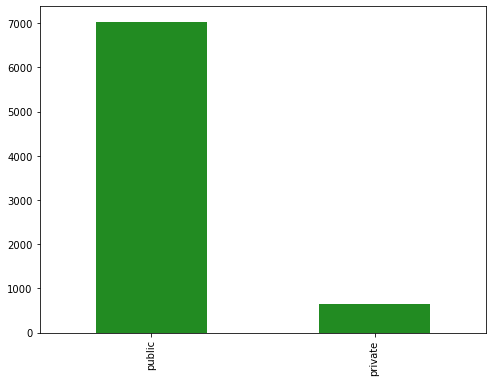

In [38]:
# EV stations: public vs private
plt.figure(figsize=[8,6])
ax = df_ev['access_code'].value_counts().plot(kind='bar', color='forestgreen')

# ratio of public / private stations is about 10.6
evratio = df_ev['access_code'].value_counts()[0]/df_ev['access_code'].value_counts()[1]
evratio

<AxesSubplot:>

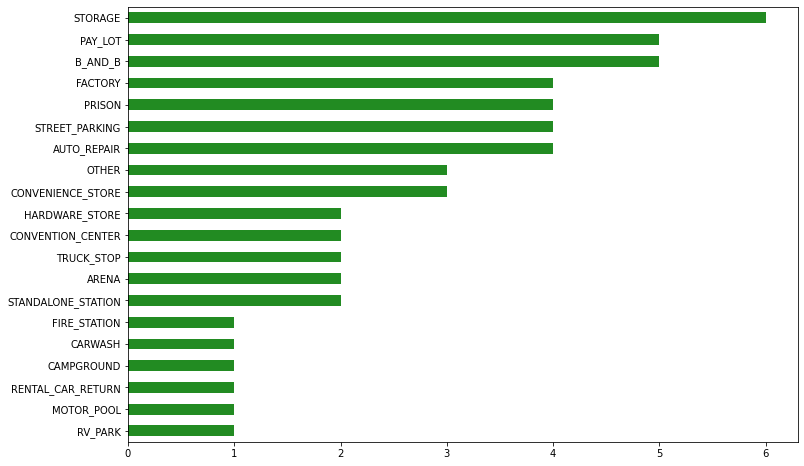

In [39]:
# EV stations: top 20 facility types
plt.figure(figsize=[12,8])
df_ev['facility_type'].value_counts().sort_values()[:20].plot(kind='barh', color='forestgreen')

ChargePoint Network    3105
Non-Networked          1316
Tesla Destination       832
EV Connect              359
Greenlots               356
eVgo Network            322
Blink Network           288
SemaCharge Network      267
Volta                   198
Tesla                   193
FLO                     180
Electrify America       165
GE WattStation           45
OpConnect                26
EVGATEWAY                18
POWERFLEX                 6
EVCS                      6
Name: ev_network, dtype: int64


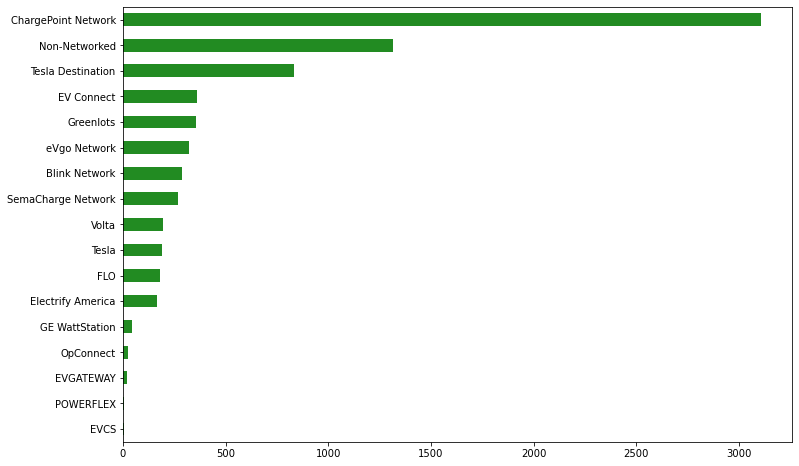

In [40]:
# EV stations: EV charging networks
plt.figure(figsize=[12,8])
df_ev['ev_network'].value_counts().sort_values().plot(kind='barh', color='forestgreen')
print(df_ev['ev_network'].value_counts().sort_values(ascending=False))

ev_dc_fast_num         5466.0
ev_level2_evse_num    28667.0
ev_level1_evse_num      496.0
dtype: float64
DC fast percentage: 15.7 %
Level 2 EVSE percentage: 82.88 %
Level 1 EVSE percentage: 1.42 %


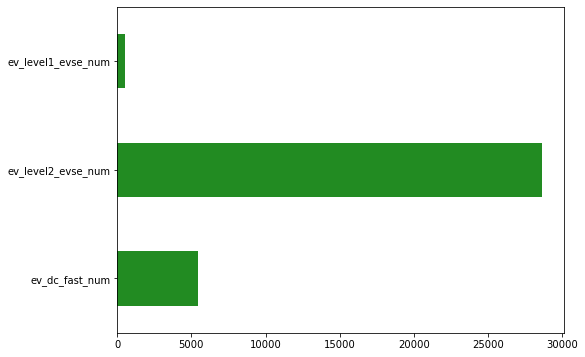

In [41]:
# EV stations: level 1, level 2 and DC Fast chargers
plt.figure(figsize=[8,6])
df_ev[['ev_dc_fast_num', 'ev_level2_evse_num', 'ev_level1_evse_num']].sum(axis=0).plot(kind='barh', color='forestgreen')
print(df_ev[['ev_dc_fast_num', 'ev_level2_evse_num', 'ev_level1_evse_num']].sum(axis=0))
print('DC fast percentage:', round(100*5405/(5405+28529+490),2), '%')
print('Level 2 EVSE percentage:', round(100*28529/(5405+28529+490),2), '%')
print('Level 1 EVSE percentage:', round(100*490/(5405+28529+490),2), '%')

### HY Stations - Characteristics

13.428571428571429

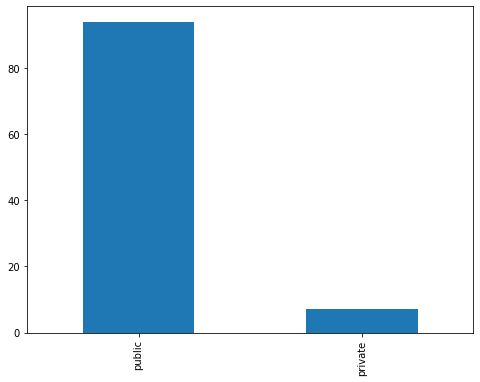

In [42]:
# HY stations: public vs private
plt.figure(figsize=[8,6])
df_hy['access_code'].value_counts().plot(kind='bar')

# ratio of public / private stations is about 13.43
hyratio = df_hy['access_code'].value_counts()[0]/df_hy['access_code'].value_counts()[1]
hyratio

<AxesSubplot:>

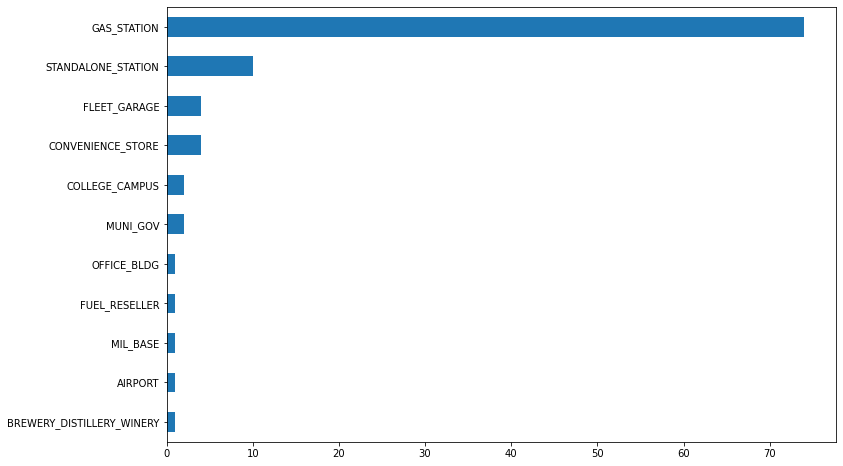

In [43]:
# HY stations: facility types
plt.figure(figsize=[12,8])
df_hy['facility_type'].value_counts().sort_values()[:20].plot(kind='barh')

12.857142857142858

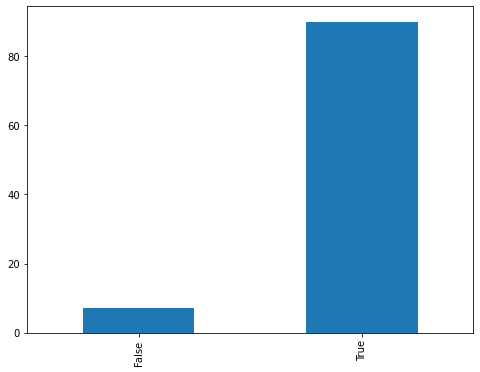

In [44]:
# HY stations: station is retail
plt.figure(figsize=[8,6])
df_hy['hy_is_retail'].value_counts().sort_values().plot(kind='bar')

# ratio of is retail vs is not retail 12.86
hyretailrat = df_hy['hy_is_retail'].value_counts()[1]/df_hy['hy_is_retail'].value_counts()[0]
hyretailrat

In [45]:
# Geoprocessing: Using Intersect to Assign Polygon ID and Attributes to Points
# spatial join points of stations with tracts
gdf_stations_proj_tracts = gpd.sjoin(gdf_stations_proj, tracts_proj, how="inner", op='intersects')
gdf_stations_proj_tracts.head(2)

geometry access_code date_last_confirmed  \
0    POINT (924836.838 3799324.883)     private          2020-09-03   
116  POINT (924668.465 3798606.266)     private          2020-09-03   

    expected_date fuel_type_code     id   open_date owner_type_code  \
0            None           ELEC   1517  1999-10-15              LG   
116          None           ELEC  33183  1999-10-15              LG   

    status_code                       station_name  ... index_right STATEFP  \
0             E           LADWP - Truesdale Center  ...        5312      06   
116           E  LADWP - Valley Generating Station  ...        5312      06   

    COUNTYFP TRACTCE              AFFGEOID        GEOID     NAME LSAD  \
0        037  121102  1400000US06037121102  06037121102  1211.02   CT   
116      037  121102  1400000US06037121102  06037121102  1211.02   CT   

       ALAND  AWATER  
0    7463001   76989  
116  7463001   76989  

[2 rows x 43 columns]

In [46]:
gdf_stations_proj_tracts.columns

Index(['geometry', 'access_code', 'date_last_confirmed', 'expected_date',
       'fuel_type_code', 'id', 'open_date', 'owner_type_code', 'status_code',
       'station_name', 'updated_at', 'facility_type', 'geocode_status', 'city',
       'state', 'street_address', 'zip', 'country', 'ev_connector_types',
       'ev_dc_fast_num', 'ev_level1_evse_num', 'ev_level2_evse_num',
       'ev_network', 'ev_network_web', 'ev_other_evse', 'ev_pricing',
       'ev_renewable_source', 'ev_network_ids', 'hy_is_retail', 'hy_pressures',
       'hy_standards', 'hy_status_link', 'federal_agency', 'index_right',
       'STATEFP', 'COUNTYFP', 'TRACTCE', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD',
       'ALAND', 'AWATER'],
      dtype='object')

### Stations by 8057 Tracts - Distribution

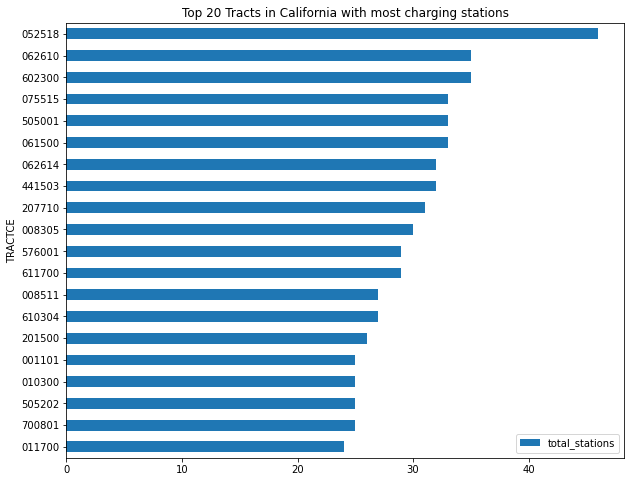

In [47]:
# top 20 tracts in California with most EV/HY charging stations
tract_stations = gdf_stations_proj_tracts.groupby('TRACTCE')['id'].count().to_frame(name='total_stations')
ax = tract_stations.sort_values('total_stations')[-20:].plot(kind='barh', title='Top 20 Tracts in California with most charging stations')
# plt.savefig('data/top 20 tracts.png', dpi=DPI, bbox_inches='tight')

In [48]:
len(tract_stations)

2478

In [49]:
round(len(tract_stations)/8047, 2)

0.31

Only 31% of all tracts in California have some EV/HY charging stations.

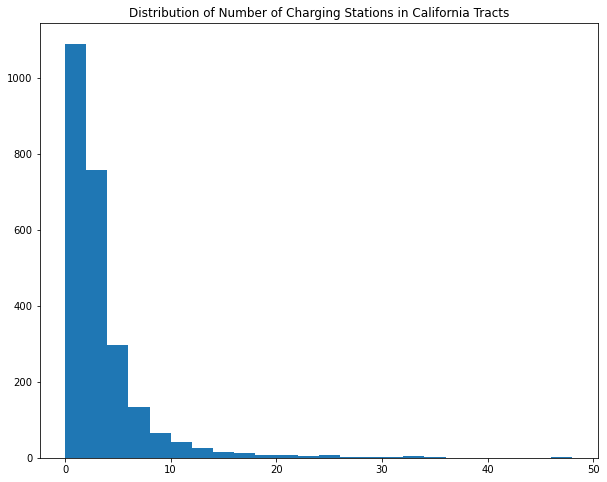

In [50]:
# distribution of number of stations in California tracts
tract_stations = gdf_stations_proj_tracts.groupby('TRACTCE')['id'].count().to_frame(name='total_stations')
plt.title('Distribution of Number of Charging Stations in California Tracts')
ax = plt.hist(tract_stations['total_stations'], bins=np.arange(0,50,2))
# plt.savefig('data/top 20 counties by charging stations in California tracts.png', dpi=DPI, bbox_inches='tight')

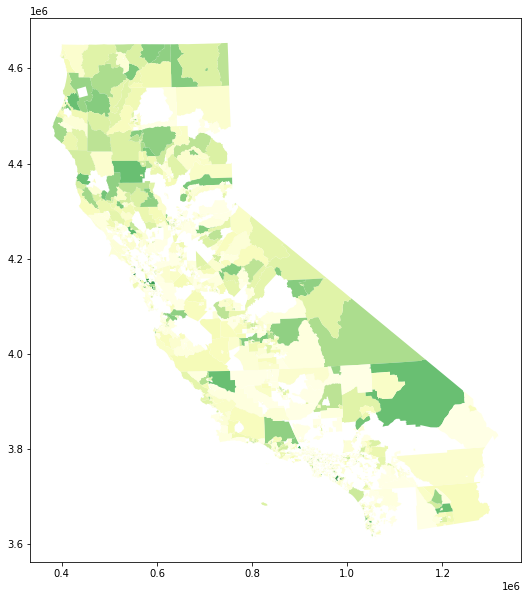

In [51]:
# Choropleth Maps of stations in tracts
tract_stat2 = pd.merge(tracts_proj, tract_stations, how='left', left_on='TRACTCE', right_index=True)
ax = tract_stat2.plot(column='total_stations', colormap = 'YlGn', figsize=(16,10))

### Stations by 58 Counties - Distribution

In [52]:
# number of EV/HY stations grouped by counties in California
county_stations = gdf_stations_proj_tracts.groupby('COUNTYFP')['id'].count().to_frame(name='total_stations').reset_index().rename(columns={'index': 'COUNTYFP'})

In [53]:
len(county_stations)

58

In [54]:
min(county_stations['total_stations'])

1

All the counties in California have at least 1 EV/HY charging station.

Reference of county and tracts
source: https://www.census.gov/geographies/reference-files/2019/demo/popest/2019-fips.html

In [55]:
# reference table of county name and county fips code
county_refer = pd.read_csv('https://raw.githubusercontent.com/kjhealy/fips-codes/master/state_and_county_fips_master.csv')
county_refer.to_csv('data/county_fips_reference.csv')
county_refer = county_refer[county_refer['state']=='CA']
county_refer.head()

fips              name state
192  6001    Alameda County    CA
193  6003     Alpine County    CA
194  6005     Amador County    CA
195  6007      Butte County    CA
196  6009  Calaveras County    CA

In [56]:
county_refer['fips'] = county_refer['fips'].apply(lambda x: x%6000)

In [57]:
county_refer = county_refer[['fips', 'name']].reset_index(drop=True)

In [58]:
county_stations['COUNTYFP'] = county_stations['COUNTYFP'].astype(int)

In [59]:
county_stations_name = pd.merge(county_stations, county_refer, how='left', left_on='COUNTYFP', right_on='fips')
county_stations_name.head()

COUNTYFP  total_stations  fips              name
0         1             369     1    Alameda County
1         3               4     3     Alpine County
2         5              12     5     Amador County
3         7              18     7      Butte County
4         9               3     9  Calaveras County

In [60]:
# reference table of county population and county name: https://www.california-demographics.com/counties_by_population
df_countypop = pd.read_csv('data/countiespop.csv')
df_countypop.head()

Rank                 County  Population
0     1     Los Angeles County    10039107
1     2       San Diego County     3338330
2     3          Orange County     3175692
3     4       Riverside County     2470546
4     5  San Bernardino County     2180085

In [61]:
county_stat_name_pop = pd.merge(county_stations_name, df_countypop, how='left', left_on='name', right_on='County')
county_stat_name_pop.head()

COUNTYFP  total_stations  fips              name  Rank            County  \
0         1             369     1    Alameda County     7    Alameda County   
1         3               4     3     Alpine County    58     Alpine County   
2         5              12     5     Amador County    46     Amador County   
3         7              18     7      Butte County    28      Butte County   
4         9               3     9  Calaveras County    44  Calaveras County   

   Population  
0     1671329  
1        1129  
2       39752  
3      219186  
4       45905

In [62]:
# reference table of county household median income: https://www.indexmundi.com/facts/united-states/quick-facts/california/median-household-income#table
df_countymedinc = pd.read_csv('data/county_medinc.csv')
df_countymedinc.head()

County  med_income
0    Alameda County       92574
1     Alpine County       64688
2     Amador County       61198
3      Butte County       48443
4  Calaveras County       58151

In [63]:
county_full = pd.merge(county_stat_name_pop, df_countymedinc, how='left', left_on='name', right_on='County')
county_full.head()

COUNTYFP  total_stations  fips              name  Rank          County_x  \
0         1             369     1    Alameda County     7    Alameda County   
1         3               4     3     Alpine County    58     Alpine County   
2         5              12     5     Amador County    46     Amador County   
3         7              18     7      Butte County    28      Butte County   
4         9               3     9  Calaveras County    44  Calaveras County   

   Population          County_y  med_income  
0     1671329    Alameda County       92574  
1        1129     Alpine County       64688  
2       39752     Amador County       61198  
3      219186      Butte County       48443  
4       45905  Calaveras County       58151

In [64]:
county_full.drop(['County_x', 'County_y', 'COUNTYFP', 'Rank'], axis=1, inplace=True)
county_full.head()

total_stations  fips              name  Population  med_income
0             369     1    Alameda County     1671329       92574
1               4     3     Alpine County        1129       64688
2              12     5     Amador County       39752       61198
3              18     7      Butte County      219186       48443
4               3     9  Calaveras County       45905       58151

In [65]:
# save a copy to csv file
county_full.to_csv('data/county_stat_pop_medinc.csv')

In [66]:
county_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 0 to 57
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   total_stations  58 non-null     int64 
 1   fips            58 non-null     int64 
 2   name            58 non-null     object
 3   Population      58 non-null     int64 
 4   med_income      58 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 2.7+ KB


In [67]:
county_full['stations_per_1000pop'] = round(1000*county_full['total_stations']/county_full['Population'], 2)

<AxesSubplot:title={'center':'Top 20 Counties in California with most EV/HY charging stations'}, ylabel='name'>

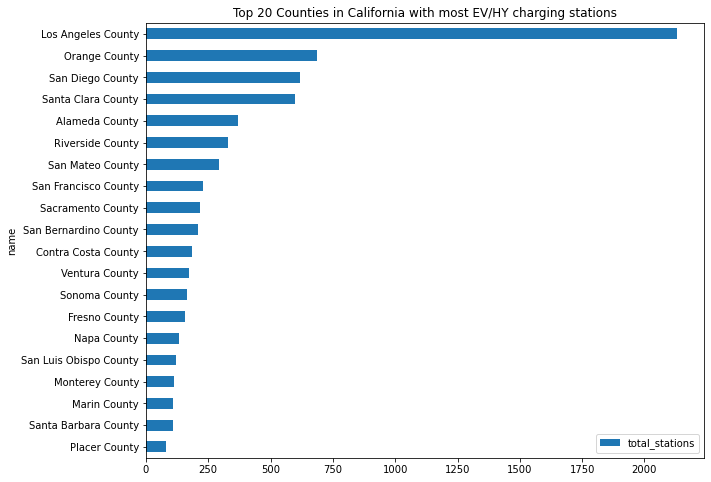

In [68]:
county_stat = county_full[['name', 'total_stations']].set_index('name')
county_stat.sort_values('total_stations')[-20:].plot(kind='barh', title='Top 20 Counties in California with most EV/HY charging stations')
# plt.savefig('data/top 20 counties by total stations.png', dpi=DPI, bbox_inches='tight')

In [69]:
stat = county_stat.sort_values(by='total_stations', ascending=False)
stat

total_stations
name                                  
Los Angeles County                2132
Orange County                      685
San Diego County                   618
Santa Clara County                 597
Alameda County                     369
Riverside County                   331
San Mateo County                   294
San Francisco County               227
Sacramento County                  216
San Bernardino County              209
Contra Costa County                184
Ventura County                     171
Sonoma County                      163
Fresno County                      157
Napa County                        132
San Luis Obispo County             121
Monterey County                    114
Marin County                       109
Santa Barbara County               108
Placer County                       82
Yolo County                         73
Solano County                       73
San Joaquin County                  62
Kern County                         55
El Dorado County                    51
Mendocino County                    49
Santa Cruz County                   49
Humboldt County                     47
Stanislaus County                   35
Tulare County                       30
Madera County                       23
Kings County                        22
Merced County                       20
Butte County                        18
Nevada County                       17
Shasta County                       17
Siskiyou County                     14
Amador County                       12
Tuolumne County                     11
San Benito County                    8
Mono County                          8
Mariposa County                      7
Del Norte County                     7
Inyo County                          6
Yuba County                          6
Lake County                          5
Sutter County                        5
Tehama County                        5
Trinity County                       4
Colusa County                        4
Alpine County                        4
Imperial County                      4
Plumas County                        4
Calaveras County                     3
Glenn County                         3
Modoc County                         2
Lassen County                        2
Sierra County                        1

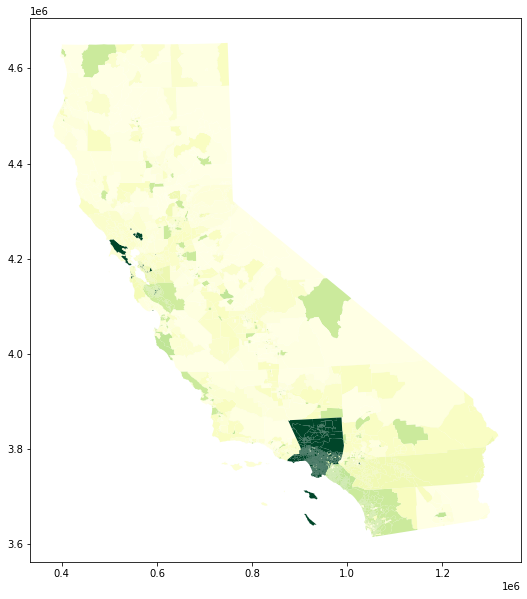

In [70]:
# Choropleth Maps of total stations in counties
county_stat2 = county_full[['fips','total_stations']]

counties_proj['COUNTYFP'] = counties_proj['COUNTYFP'].apply(lambda x: int(x))
counties_proj = counties_proj.set_index('COUNTYFP')

stat2 = pd.merge(counties_proj, county_stat2, how='left', left_index=True, right_on='fips')
ax = stat2.plot(column='total_stations', colormap = 'YlGn', figsize=(16, 10))

In [71]:
print(stat.describe())

       total_stations
count       58.000000
mean       134.224138
std        307.914208
min          1.000000
25%          6.250000
50%         32.500000
75%        129.250000
max       2132.000000


As for total stations by counties, the maximum is 2131 (LA county), minimum is 1 (Sierra County), median is 32.5 (Tulare County and Madera County), 75% percentile is 129.25 (Napa County and San Luis Obispo County), and 25% percentile is 6.25 (Yuba County, Inyo County, Del Norte County and Mariposa County).

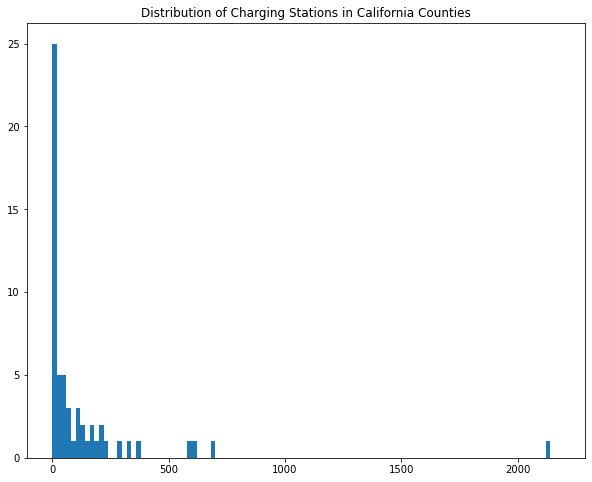

In [72]:
plt.title('Distribution of Charging Stations in California Counties')
ax = plt.hist(stat['total_stations'], bins=np.arange(0,2200,20))
# plt.savefig('data/Distribution of Charging Stations in California Counties.png', dpi=DPI, bbox_inches='tight')

In [73]:
# IQR method to find outliers
Q1, Q3 = 6.25, 129.25
IQR = Q3-Q1
lower = Q1-1.5*IQR
upper = Q3+1.5*IQR
outliers = stat[(stat['total_stations']>upper) | (stat['total_stations']<lower)]
print(outliers)

                    total_stations
name                              
Los Angeles County            2132
Orange County                  685
San Diego County               618
Santa Clara County             597
Alameda County                 369
Riverside County               331


We find these 6 counties as outliers exceeding the upper bound. They stand out with more stations than others. However, it could be the case these counties are more populated than others. We can check the total stations per 1000 population.

<AxesSubplot:title={'center':'Top 20 Counties with most EV/HY charging stations per 1000 population'}, ylabel='name'>

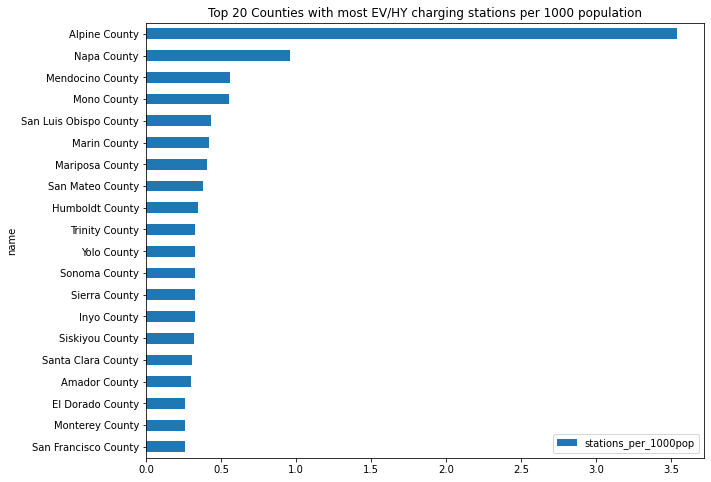

In [74]:
county_stat_perpop = county_full[['name', 'stations_per_1000pop']].set_index('name')
county_stat_perpop.sort_values('stations_per_1000pop')[-20:].plot(kind='barh', title='Top 20 Counties with most EV/HY charging stations per 1000 population')
# plt.savefig('data/top 20 counties by stations per 1000 population.png', dpi=DPI, bbox_inches='tight')

In [75]:
stat_pop = county_stat_perpop.sort_values(by='stations_per_1000pop', ascending=False)
stat_pop

stations_per_1000pop
name                                        
Alpine County                           3.54
Napa County                             0.96
Mendocino County                        0.56
Mono County                             0.55
San Luis Obispo County                  0.43
Marin County                            0.42
Mariposa County                         0.41
San Mateo County                        0.38
Humboldt County                         0.35
Sierra County                           0.33
Sonoma County                           0.33
Inyo County                             0.33
Trinity County                          0.33
Yolo County                             0.33
Siskiyou County                         0.32
Santa Clara County                      0.31
Amador County                           0.30
El Dorado County                        0.26
San Francisco County                    0.26
Monterey County                         0.26
Del Norte County                        0.25
Santa Barbara County                    0.24
Modoc County                            0.23
Alameda County                          0.22
Orange County                           0.22
Los Angeles County                      0.21
Placer County                           0.21
Plumas County                           0.21
Ventura County                          0.20
Tuolumne County                         0.20
San Diego County                        0.19
Colusa County                           0.19
Santa Cruz County                       0.18
Nevada County                           0.17
Fresno County                           0.16
Contra Costa County                     0.16
Solano County                           0.16
Madera County                           0.15
Sacramento County                       0.14
Kings County                            0.14
San Benito County                       0.13
Riverside County                        0.13
Glenn County                            0.11
San Bernardino County                   0.10
Shasta County                           0.09
Yuba County                             0.08
San Joaquin County                      0.08
Tehama County                           0.08
Lake County                             0.08
Butte County                            0.08
Calaveras County                        0.07
Merced County                           0.07
Lassen County                           0.07
Tulare County                           0.06
Stanislaus County                       0.06
Kern County                             0.06
Sutter County                           0.05
Imperial County                         0.02

In [76]:
print(stat_pop.describe())

       stations_per_1000pop
count             58.000000
mean               0.279483
std                0.463577
min                0.020000
25%                0.102500
50%                0.200000
75%                0.317500
max                3.540000


Checking the stations per 1000 population in counties, the maximum is 3.54 (Alpine County), minimum is 0.02 (Imperial County), median is 0.2 (Placer County, Tuolumne County and Ventura County), 75% percentile is 0.317 (Siskyo County and Santa Clara County), and 25% percentile is 0.1025 (San Bernardino County).

In [77]:
# IQR method to find outliers
q1, q3 = 0.1025, 0.3175
iqr = q3-q1
low = q1-1.5*iqr
up = q3+1.5*iqr
Outliers = stat_pop[(stat_pop['stations_per_1000pop']>up) | (stat_pop['stations_per_1000pop']<low)]
print(Outliers)

               stations_per_1000pop
name                               
Alpine County                  3.54
Napa County                    0.96


We also find two outliers, Alpine County and Napa County. Alpine County has the least population among all counties in CA. Napa County ranked 34 among 58 states in population, however Napa's total staitons per population stands out as much higher than others. One possible reason is that Napa has very high traffic of tourists from other places, so that more stations are built to serve the demand from tourists rather than the residents in Napa.

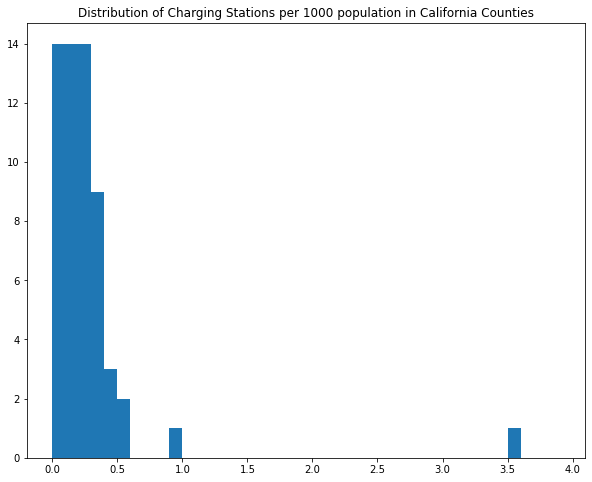

In [78]:
plt.title('Distribution of Charging Stations per 1000 population in California Counties')
ax = plt.hist(stat_pop['stations_per_1000pop'], bins=np.arange(0,4,0.1))
# plt.savefig('data/Distribution of Charging Stations per 1000 population in California Counties.png', dpi=DPI, bbox_inches='tight')

Except Alpine County and Napa County, most counties have no more than 0.5 stations per 1000 population. About half of the counties have no more than 0.2 stations per 1000 population. 

# Section 5: OLS Linear Regression

Regressing Population and Median Household Income on Total Stations (county level)

In [79]:
stat_inc = county_full[['name', 'total_stations', 'Population', 'med_income']].set_index('name')
stat_inc.head()

total_stations  Population  med_income
name                                                    
Alameda County               369     1671329       92574
Alpine County                  4        1129       64688
Amador County                 12       39752       61198
Butte County                  18      219186       48443
Calaveras County               3       45905       58151

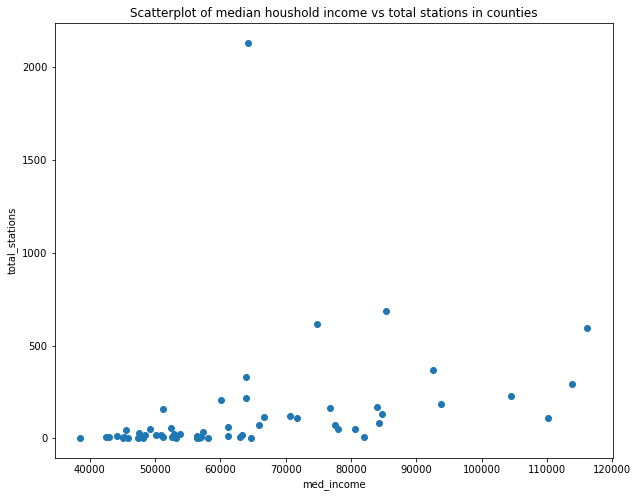

In [80]:
# create scatterplot to oberve relations between median household income and total stations in counties
plt.title('Scatterplot of median houshold income vs total stations in counties')
plt.ylabel('total_stations')
plt.xlabel('med_income')
ax = plt.scatter(y=stat_inc['total_stations'], x=stat_inc['med_income'])

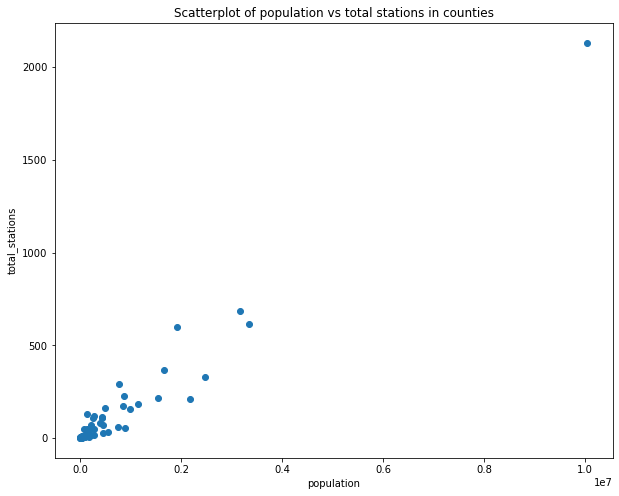

In [81]:
# create scatterplot to oberve relations between populations and total stations in counties
plt.title('Scatterplot of population vs total stations in counties')
plt.ylabel('total_stations')
plt.xlabel('population')
ax = plt.scatter(y=stat_inc['total_stations'], x=stat_inc['Population'])

Judging from both graphs, there seems to be some heteroskedasticity. We should use robust standard error in OLS to remedy this.

In [82]:
# check multicollinearity using VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = stat_inc[['Population', 'med_income']]

vif_data = pd.DataFrame()
vif_data['features'] = X.columns

vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

     features       VIF
0  Population  1.271406
1  med_income  1.271406


The VIF for population and med_income are all less than 5, so they are not strongly correlated. We can keep both independent variables.

In [83]:
# run OLS linear regression: total stations ~ population + med_income
# using robust standard error, with all data
import statsmodels.api as sm

X = stat_inc[['Population', 'med_income']]
y = stat_inc['total_stations']

X = sm.add_constant(X)
mod = sm.OLS(y, X).fit(cov_type='HC1')
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_stations   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     236.7
Date:                Tue, 22 Dec 2020   Prob (F-statistic):           9.47e-28
Time:                        16:31:01   Log-Likelihood:                -317.04
No. Observations:                  58   AIC:                             640.1
Df Residuals:                      55   BIC:                             646.3
Df Model:                           2                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -106.5499     29.098     -3.662      0.000    -163.582     -49.518
Population     0.0002   1.09e-05     18.398      0.000       0.000       0.000
med_income     0.0016      0.000      3.322      0.001       0.001       0.003
==============================================================================
Omnibus:                       21.848   Durbin-Watson:                   1.723
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.947
Skew:                          -1.198   Prob(JB):                     2.12e-09
Kurtosis:                       6.284   Cond. No.                     5.81e+06
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 5.81e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

According to the OLS above, we find both coefficients of Population and Median Income are 99% statistically significant. Our interpretation is that every 10,000 people added in county population is associated with 2 more EV/HY charging stations, holding county household median income level constant. Also, every 1000 dollars added in county median household income is associated with 1.6 additional EV/HY charging stations, holding county population constant. The adjusted R-squared is about 96%, meaning these two variables (income and population) can explain 96% of the variations in total stations. However, the very large condition number might indicate some numerical problems.

Our main takeaway from the observational study is that counties with more population or high income level are in general have more charging stations. However, we are only talking about correlation rather than causation. There could be other factors omitted in the formula and the causal relation can also be the other way around.

In [84]:
# run again the regression without outliers
# outliers in total stations
outliers

total_stations
name                              
Los Angeles County            2132
Orange County                  685
San Diego County               618
Santa Clara County             597
Alameda County                 369
Riverside County               331

In [85]:
# drop 6 outliers in total_stations
stat_inc_clean = stat_inc[~stat_inc['total_stations'].isin(outliers['total_stations'])]
stat_inc_clean.shape

(52, 3)

In [86]:
# run OLS again without outliers, using robust standard error
X1 = stat_inc_clean[['Population', 'med_income']]
y1 = stat_inc_clean['total_stations']

X1 = sm.add_constant(X1)
mod = sm.OLS(y1, X1).fit(cov_type='HC1')
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_stations   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     79.12
Date:                Tue, 22 Dec 2020   Prob (F-statistic):           4.53e-16
Time:                        16:31:01   Log-Likelihood:                -250.32
No. Observations:                  52   AIC:                             506.6
Df Residuals:                      49   BIC:                             512.5
Df Model:                           2                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -101.3097     21.631     -4.684      0.000    -143.705     -58.914
Population     0.0001   1.27e-05      8.189      0.000    7.92e-05       0.000
med_income     0.0020      0.000      5.076      0.000       0.001       0.003
==============================================================================
Omnibus:                        2.346   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.309   Jarque-Bera (JB):                1.855
Skew:                           0.462   Prob(JB):                        0.396
Kurtosis:                       3.023   Cond. No.                     2.02e+06
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 2.02e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

I also tried to drop the outliers in total stations and ran the OLS again. Both coefficients of Population and Median Income are 99% statistically significant. Our interpretation is that every 10,000 people added in county population is associated with 1 more EV/HY charging station, holding county household median income level constant. Also, every 1000 dollars added in county median household income is associated with 2 additional EV/HY charging stations, holding county population constant. The adjusted R-squared is about 82%, meaning these two variables (income and population) can explain 82% of the variations in total stations. 
